# PPO v DQN

## A Duel at the Limits of Handling

Alberto Guiggiani

Stanford AA228 Fall 2023 - Decision Making Under Uncertainty - Final Project

---

Jupyter Notebook featuring:

* Set-up of the [Gymnasium Car Racing Environment](https://gymnasium.farama.org/environments/box2d/car_racing/)
* Implementation and training of a Proximal Policy Optimization algorithm via [StableBaseline3 API](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)
* Implementation and training of a Deep Q-Network Algorithm
* Simulation and benchmarking

### Getting Started

Create and activate a new venv from the provided `requirements.txt` (recommended Python 3.11)

```bash
pip install virtualenv
virtualenv venv
source venv/bin/activate
pip install -r requirements.txt
```

Be wary that the training step are time-consuming and are disabled by flags. Weights are provided for quick execution.

In [2]:
# Import required libraries

%matplotlib widget
import pandas as pd
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation
import cv2
import time
from collections import OrderedDict
from datetime import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Define helper functions

def preprocess(img):
    """
    Preprocesses an image by converting it to grayscale and normalizing pixel values.

    Args:
        img (numpy.ndarray): The input image.

    Returns:
        numpy.ndarray: The preprocessed image.
    """
    return cv2.cvtColor(img[:84, 6:90], cv2.COLOR_RGB2GRAY) / 255.0

def plot(s):
    """
    Plots a set of images in a row.

    Args:
        s (numpy.ndarray): The set of images to plot.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(4):
        axes[i].imshow(s[i], cmap='gray')
        axes[i].axis('off')
    fig.tight_layout()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    plt.show()

def animate(frames, interval=60, save_path=None):
    """
    Creates an animation from a set of frames.

    Args:
        frames (list): The list of frames to animate.
        interval (int): The interval between frames in milliseconds.
        save_path (str): The path to save the animation as a video file (optional).

    Returns:
        matplotlib.animation.FuncAnimation: The animation object.
    """
    fig = plt.figure(figsize=(5, 3))
    plt.axis('off')
    im = plt.imshow(frames[0])
    def callback(i):
        im.set_array(frames[i])
        return im
    fig.tight_layout()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False

    anim = matplotlib.animation.FuncAnimation(fig, callback, frames=len(frames), interval=interval)

    if save_path:
        anim.save(save_path, writer='ffmpeg')

    return anim

def simulate(model, render=True):
    """
    Simulates the environment using a trained model.

    Args:
        model: The trained model.
        render (bool): Whether to render the simulation or not.

    Returns:
        tuple: A tuple containing the total reward and the list of frames.
    """
    env = model.get_env()
    frames = []
    done = False
    total_reward = 0
    obs = env.reset()
    while not done:
        if render:
            frames.append(env.render())
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward

    env.close()
    return total_reward, frames

## Proximal Policy Optimization

Implementation and training via StableBaselines3 API

In [3]:
# Train the model - time consuming!
N_iter = 500000

# Set flag to true to execute
# The best model will be stored in ./training/ppo_YYYYMMDD_HHMMSS/best_model.zip
if False:
    env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
    env = DummyVecEnv([lambda: env])

    log_path = os.path.join('./logs')

    model = PPO('CnnPolicy',
                env,
                verbose=1,
                tensorboard_log=log_path,
                device='auto',
                batch_size=128)

    ppo_path = os.path.join('./training/ppo_' + datetime.now().strftime("%Y%m%d_%H%M%S"))

    eval_callback = EvalCallback(eval_env=model.get_env(),
                                best_model_save_path=ppo_path,
                                n_eval_episodes=5,
                                eval_freq=50000,
                                verbose=1,
                                deterministic=True,
                                render=False)

    model.learn(total_timesteps=N_iter, callback=eval_callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Total reward: [873.79236]


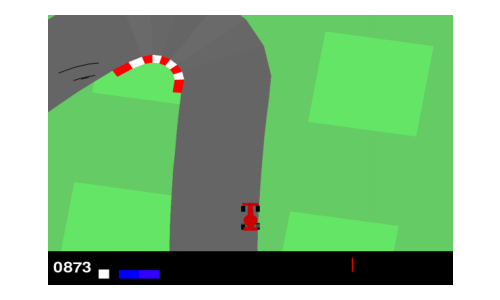

In [4]:
# Simulate the environment

# Use provided weights - replace with your own from training if desired
best_model_path = './weights/ppo.zip'

# Save animation to file - set to none to skip
animation_path = './ppo_animation.mp4'

# Load the model and run the simulation
env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
model = PPO.load(best_model_path, env=env)
reward, frames = simulate(model)
print('Total reward:', reward)
animate(frames, save_path=animation_path)

In [5]:
# Benchmark PPO - time consuming!
# Run N_sims simulations and save the results to a csv file
N_sims = 100
csv_path = './data/ppo_benchmark.csv'

# Set flag to true to execute
if False:

    env = gym.make('CarRacing-v2', continuous=False)
    model = PPO.load(os.path.join('./training/ppo_20231112_092443/best_model.zip'), env=env)

    rewards_PPO = []
    for i in range(N_sims):
        reward, _ = simulate(model, render=False)
        rewards_PPO.append(reward)
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{N_sims}")

    rewards_PPO_df = pd.DataFrame(rewards_PPO, columns=['Reward'])
    rewards_PPO_df.to_csv(csv_path, index=False)


## Deep-Q Networks

Vanilla PyTorch implementation

Based on the tutorial in: https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html

In [6]:
# Define the environment wrapper

class CarEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip=4,
        stack=4,
        no_op=50,
        **kwargs
    ):
        """
        Custom environment wrapper for the Car Racing environment.

        Args:
            env (gym.Env): The original Car Racing environment.
            skip (int): Number of steps to skip between actions.
            stack (int): Number of frames to stack as input.
            no_op (int): Number of no-op steps to take at the beginning of each episode.
            **kwargs: Additional keyword arguments to pass to the gym.Wrapper constructor.
        """
        super(CarEnv, self).__init__(env, **kwargs)
        self.no_op = no_op
        self.skip = skip
        self.stack = stack

    def reset(self, seed=None):
        """
        Reset the environment and return the initial state.

        Args:
            seed (int): The random seed for the environment.

        Returns:
            tuple: A tuple containing the initial state and additional information.
        """
        # Do nothing for the first `self.no_op` steps
        s, info = self.env.reset(seed=seed)
        for _ in range(self.no_op):
            s, r, terminate, truncate, info = self.env.step(0)

        # Convert frame to gray scale and rescale
        s = preprocess(s)

        self.stacked_state = np.tile(s, (self.stack, 1, 1))
        return self.stacked_state, info

    def step(self, action):
        """
        Take a step in the environment.

        Args:
            action: The action to take.

        Returns:
            tuple: A tuple containing the next state, reward, termination flag, truncation flag, and additional information.
        """
        # Take the selected action for self.skip steps
        reward = 0
        for _ in range(self.skip):
            s, r, terminate, truncate, info = self.env.step(action)
            reward += r
            if terminate or truncate:
                break

        # Convert frame to gray scale and rescale
        s = preprocess(s)

        # Push the frame at the end of the stack
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminate, truncate, info


env.observation_space=Box(0, 255, (96, 96, 3), uint8)
env.action_space=Discrete(5)


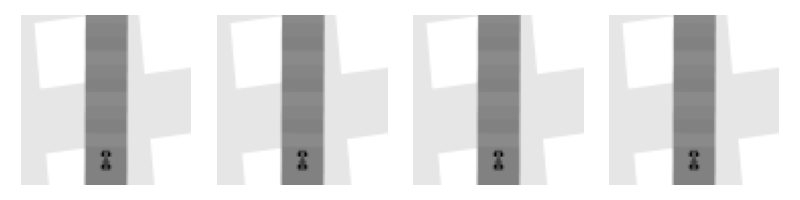

In [7]:
# Create an environment and run a sanity check on the action and observation spaces

env = CarEnv(gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array'))
print(f"{env.observation_space=}")
print(f"{env.action_space=}")

s, _ = env.reset()
plot(s)

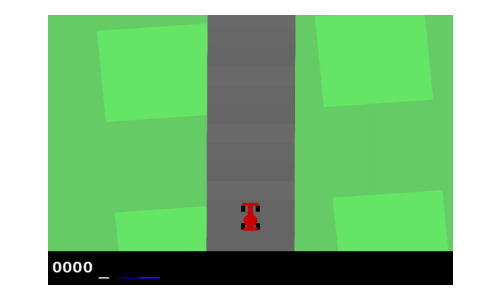

In [8]:
# Accelerate and run a sanity check on vehicle movement and animation function

frames = []
env = CarEnv(gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array'))
env.reset()
completed = False
while not completed:
    s, r, terminate, truncate, info = env.step(3)
    completed = terminate or truncate
    frames.append(env.render())

animate(frames)

In [9]:
# Define helper classes

class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        """
        Convolutional Neural Network for Action-Value estimation.

        Args:
            state_dim (tuple): The dimensions of the input state.
            action_dim (int): The number of possible actions.
            activation (function): The activation function to use (default: ReLU).
        """
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)  # [N, 4, 84, 84] -> [N, 16, 20, 20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features = 32 * 9 * 9
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        """
        Forward pass of the CNNActionValue network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view((-1, self.in_features))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        """
        Replay buffer for storing and sampling experience tuples.

        Args:
            state_dim (tuple): The dimensions of the state.
            action_dim (int): The number of possible actions.
            max_size (int): The maximum size of the replay buffer (default: 100,000).
        """
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        """
        Update the replay buffer with a new experience tuple.

        Args:
            s (np.ndarray): The current state.
            a (np.ndarray): The action taken.
            r (float): The reward received.
            s_prime (np.ndarray): The next state.
            terminated (float): Whether the episode terminated or not.

        Returns:
            None
        """
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        """
        Sample a batch of experience tuples from the replay buffer.

        Args:
            batch_size (int): The size of the batch to sample.

        Returns:
            tuple: A tuple containing the sampled states, actions, rewards, next states, and termination flags.
        """
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]),
        )

In [10]:
# Define the main DQN class

class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_min_steps=1e6,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        """
        Deep Q-Network (DQN) class for reinforcement learning.

        Args:
            state_dim (tuple): The dimensions of the state.
            action_dim (int): The number of possible actions.
            lr (float): The learning rate (default: 0.00025).
            epsilon (float): The exploration rate (default: 1.0).
            epsilon_min (float): The minimum exploration rate (default: 0.1).
            epsilon_min_steps (float): The number of steps to reach the minimum exploration rate (default: 1e6).
            gamma (float): The discount factor (default: 0.99).
            batch_size (int): The size of the batch for training (default: 32).
            warmup_steps (int): The number of warmup steps before training starts (default: 5000).
            buffer_size (int): The size of the replay buffer (default: 100,000).
            target_update_interval (int): The interval at which to update the target network (default: 10,000).
        """
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('mps')
        self.network.to(self.device)
        self.target_network.to(self.device)

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / epsilon_min_steps

    @torch.no_grad()
    def act(self, x, training=True):
        """
        Select an action based on the current state.

        Args:
            x (np.ndarray): The current state.
            training (bool): Whether the agent is in training mode or not (default: True).

        Returns:
            int: The selected action.
        """
        self.network.train(training)
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.network(x)
            a = torch.argmax(q).item()
        return a

    def learn(self):
        """
        Perform a single learning step.

        Returns:
            dict: A dictionary containing the learning results.
        """
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))

        next_q = self.target_network(s_prime).detach()
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.item(),
            'epsilon': self.epsilon,
        }
        return result

    def process(self, transition):
        """
        Process a transition and update the agent.

        Args:
            transition (tuple): The transition tuple containing the current state, action, reward, next state, and termination flag.

        Returns:
            dict: A dictionary containing the processing results.
        """
        self.total_steps += 1
        result = {
            'total_steps': self.total_steps,
            'value_loss': 0,
            'epsilon': self.epsilon,
        }
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()

        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon -= self.epsilon_decay
        self.epsilon = max(self.epsilon, 0.1)
        return result

In [11]:
# Train the model - time consuming!
max_steps = int(2000001)
eval_interval = 50000
buffer_size = int(1e4)
warmup_steps = int(5000)
epsilon = 1.0
epsilon_min = 0.1
epsilon_min_steps = int(max_steps // 2)
weights_path = './weights/dqn.pt'
data_path = './data/dqn.csv'

# Set flag to true to execute
if False:
    env = CarEnv(gym.make('CarRacing-v2', continuous=False))

    state_dim = (4, 84, 84)
    action_dim = env.action_space.n

    agent = DQN(
        state_dim,
        action_dim,
        buffer_size=buffer_size,
        warmup_steps=warmup_steps,
        epsilon=epsilon,
        epsilon_min=epsilon_min,
        epsilon_min_steps=epsilon_min_steps)

    def evaluate(n_evals=5, agent=agent):
        eval_env = gym.make('CarRacing-v2', continuous=False)
        eval_env = CarEnv(eval_env)

        scores = 0
        for i in range(n_evals):
            (s, _), done, ret = eval_env.reset(), False, 0
            while not done:
                a = agent.act(s, training=False)
                s_prime, r, terminated, truncated, info = eval_env.step(a)
                s = s_prime
                ret += r
                done = terminated or truncated
            scores += ret
        return np.round(scores / n_evals, 4)

    history = {'step': [], 'avg_return': [], 'value_loss': [], 'epsilon': []}

    (s, _) = env.reset()
    start_time = time.time()
    best_return = -np.inf
    while True:
        a = agent.act(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.

        s = s_prime
        if terminated or truncated:
            s, _ = env.reset()

        # Calculate average time per step
        avg_time_per_step = (time.time() - start_time) / agent.total_steps
        if agent.total_steps % 5000 == 0:
            print(f"Step: {agent.total_steps}, Avg FPS: {1/avg_time_per_step:.4f}s, Value Loss: {result['value_loss']}, Epsilon: {result['epsilon']}, Remaining: {(max_steps - agent.total_steps) * avg_time_per_step / 60:.2f} minutes""")

        if agent.total_steps % eval_interval == 0:
            ret = evaluate(agent=agent)
            history['step'].append(agent.total_steps)
            history['avg_return'].append(ret)
            history['value_loss'].append(result['value_loss'])
            history['epsilon'].append(result['epsilon'])

            print(f"Return: {ret}")
            torch.save(agent.network.state_dict(), weights_path)

            # Export history to CSV
            df = pd.DataFrame(history)
            df.to_csv(data_path, index=False)

        if agent.total_steps > max_steps:
            break



Return: 595.9722222222103


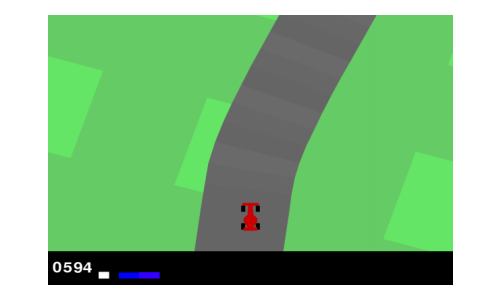

In [13]:
# Simulate the environment with DQN

# Use provided weights - replace with your own from training if desired
best_model_path = './weights/dqn.pt'

# Save animation to file - set to none to skip
animation_path = './dqn_animation.mp4'

# Load the model and create the environment
env = CarEnv(gym.make('CarRacing-v2', continuous=False))
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim)
agent.network.load_state_dict(torch.load(best_model_path))
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnv(eval_env)

# Simulate the environment
frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s, r, terminated, truncated, info = eval_env.step(a)
    ret += r
    done = terminated or truncated
scores += ret

print(f"Return: {ret}")
animate(frames, save_path=animation_path)

In [14]:
# Benchmark DQN - time consuming!
# Run N_sims simulations and save the results to a csv file
N_sims = 100
csv_path = './data/dqn_benchmark.csv'

# Set flag to true to execute
if False:

    state_dim = (4, 84, 84)
    action_dim = env.action_space.n
    agent = DQN(state_dim, action_dim)
    agent.network.load_state_dict(torch.load('dqn.pt'))

    eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
    eval_env = CarEnv(eval_env)

    rewards_DQN = []
    for i in range(N_sims):
        frames = []
        reward = 0
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            frames.append(eval_env.render())
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = eval_env.step(a)
            ret += r
            done = terminated or truncated
        reward += ret
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/N_sims")
        rewards_DQN.append(reward)

    rewards_DQN = pd.DataFrame(rewards_DQN, columns=['Reward'])
    rewards_DQN.to_csv(csv_path, index=False)

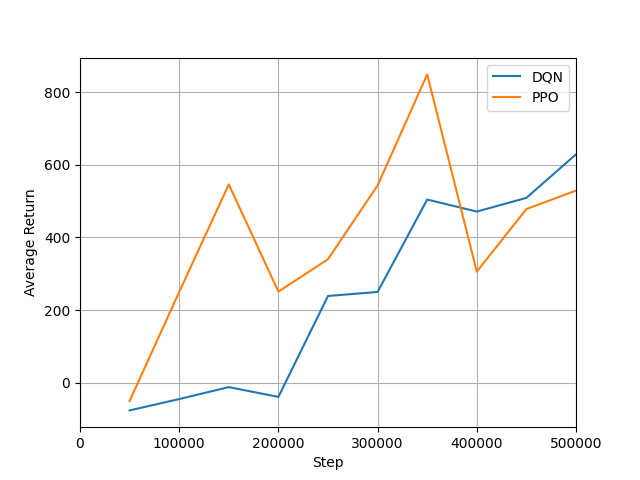

In [19]:
# Plot the training results
dqn_path = './data/training_dqn.csv'
ppo_path = './data/training_ppo.csv'
fig_path = './plots/plot_training_return.svg'

# Load DQN data
dqn_data = pd.read_csv(dqn_path)

# Create a new figure
fig, ax = plt.subplots()

# Plot "step" vs "avg_return"
ax.plot(dqn_data['step'], dqn_data['avg_return'], label='DQN')

# Load data from ppo_log_reward.csv
ppo_data = pd.read_csv(ppo_path)

# Plot "Step" vs "Value"
ax.plot(ppo_data['Step'], ppo_data['Value'], label='PPO')

# Set the x-axis limit to 500k
ax.set_xlim(0, 500000)

# Enable the grid
ax.grid(True)

# Add labels and legend
ax.set_xlabel('Step')
ax.set_ylabel('Average Return')
ax.legend()

# Save the plot to SVG file
fig.savefig(fig_path, format='svg')



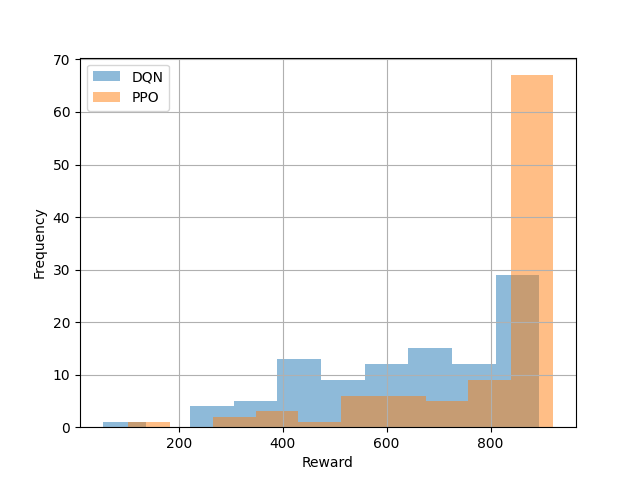

In [20]:
# Plot the evaluation results
# Histogram of rewards
import matplotlib.pyplot as plt

dqn_path = './data/rewards_dqn.csv'
ppo_path = './data/rewards_ppo.csv'
fig_path = './plots/plot_histogram.svg'

# Load data
rewards_DQN = pd.read_csv(dqn_path)
rewards_PPO = pd.read_csv(ppo_path)

# Plot histogram
fig_hist, ax_hist = plt.subplots()
ax_hist.hist(rewards_DQN['Reward'], bins=10, alpha=0.5, label='DQN')
ax_hist.hist(rewards_PPO['Reward'], bins=10, alpha=0.5, label='PPO')

# Enable grid
ax_hist.grid(True)

# Add labels and legend
ax_hist.set_xlabel('Reward')
ax_hist.set_ylabel('Frequency')
ax_hist.legend()

# Save the plot to SVG file
plt.savefig(fig_path, format='svg')

# Show the plot
plt.show()
